In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
import json
from utils.utils import get_consecutives

import fastf1
import fastf1.plotting

fastf1.Cache.enable_cache('./data')  

## Variables

In [3]:
#constants
YEAR = 2023

#dicts
with open('./data/teams.json', 'r') as file:
    teams = json.load(file)


In [4]:
# a class to hold all race data
class RaceData():
    '''
    this class holds all of the sessions for the gp weekend.
    '''
    def __init__(self):
        self.race = None
        self.quali = None
        self.p1 = None
        self.p2 = None
        self.p3 = None
        self.sprint = None
        self.sprint_quali = None
        self.event_type = ''
        
    def load(self):
        self.race.load()
        self.quali.load()
        self.p1.load()
        
        if self.event_type == 'conventional':
            self.p2.load()
            self.p3.load()
        if self.event_type == 'Sprint Shootout':
            self.sprint_quali.load()
            self.sprint.load()
    
    def get_data(self,year, race,load=True):
        event = fastf1.get_event(year, race)
        self.event_type = event['EventFormat']

        # practice
        self.p1 = event.get_practice(1)
        if self.event_type == 'conventional':
            self.p2 = event.get_practice(2)
            self.p3 = event.get_practice(3)
        elif self.event_type == 'Sprint Shootout':
            self.sprint_quali = event.get_session(3)
            self.sprint = event.get_sprint()
        
        # sessions
        self.quali = event.get_qualifying()
        self.race = event.get_race()
        
        if load:
            self.load()
        
race1 = RaceData()
race1.get_data(YEAR,'Abu Dhabi Grand Prix')
        

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
c:\Users\batuu\anaconda3\envs\tf\lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
c:\Users\batuu\anaconda3\envs\tf\lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
c:\Users\

no sc


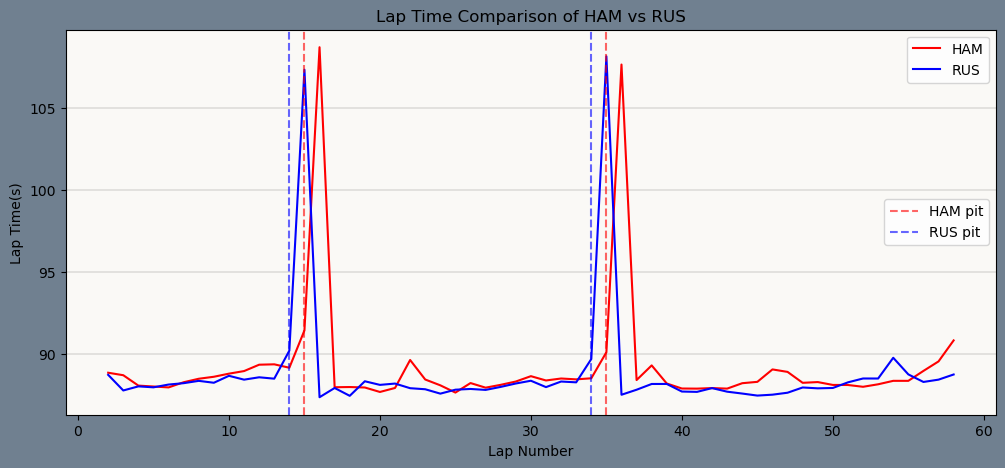

In [5]:
def comp_drivers(data: RaceData,driver1,driver2,fuel_comparison=False,sc=False,pit=True):
    
    lap_comp = pd.DataFrame()
    driver_laps1 = data.race.laps.pick_driver(driver1).reset_index()
    driver_laps2 = data.race.laps.pick_driver(driver2).reset_index()
    
    pits1 = driver_laps1.loc[driver_laps1['PitInTime'].notna()]
    pits2 = driver_laps2.loc[driver_laps2['PitInTime'].notna()]
    
    lap_comp['Lap'] = driver_laps1['LapNumber']
    lap_comp[driver1] = driver_laps1['LapTime'].dt.total_seconds()
    lap_comp[driver2] = driver_laps2['LapTime'].dt.total_seconds()
    
    safety_laps = driver_laps1[driver_laps1['TrackStatus'].str.contains('4')]['LapNumber']
    vsc_laps = driver_laps1[driver_laps1['TrackStatus'].str.contains('6')]['LapNumber']
    
    
    yellow_periods = get_consecutives(safety_laps)
    
    f, ax = plt.subplots(figsize=(12,5))
    if fuel_comparison:
        fuel_comp = np.arange(len(lap_comp),0,-1)
        fuel_comp = fuel_comp/20
        lap_comp[driver1] = lap_comp[driver1] - fuel_comp
        lap_comp[driver2] = lap_comp[driver2] - fuel_comp
        
    ax = sns.lineplot(data=lap_comp,x='Lap',y=driver1,color='r',label=driver1)
    f.set_facecolor('#708090')
    ax.set_facecolor('#FAF9F6')
    sns.lineplot(data=lap_comp,x='Lap',y=driver2,color='b',ax=ax,label=driver2)
    sns.move_legend(ax,'upper right')
    time_leg = ax.get_legend()
    
    handles = []
    
    if pit:
        for i in pits1['LapNumber'].values:
            p1 = plt.axvline(i,color='r', linestyle='--',alpha=0.6,label=f'{driver1} pit')
        
        for i in pits2['LapNumber'].values:
            if i in pits1['LapNumber'].values:
                i+=.3
            p2 = plt.axvline(i,color='b',linestyle='--',alpha=0.6,label=f'{driver2} pit')
        handles = handles+[p1,p2]
        
    if sc:
        safety_laps = driver_laps1[driver_laps1['TrackStatus'].str.contains('4')]['LapNumber']
        vsc_laps = driver_laps1[driver_laps1['TrackStatus'].str.contains('6')]['LapNumber']
        if (len(safety_laps) + len(vsc_laps)) == 0:
            print('no sc')
            pass
        
        yellow_periods = get_consecutives(safety_laps)
        vsc_periods = get_consecutives(vsc_laps)
        
        if len(yellow_periods) > 0:
            for period in yellow_periods:
                scars = ax.axvspan(period[0],period[-1],0,color='yellow',alpha=0.4,label='Safety Car')
                #ax.fill_between(yellow_periods[0][0],yellow_periods[0][-1],0,color='yellow',alpha=0.5)
                handles.append(scars)
            
        if len(vsc_periods) >0:
            for period in vsc_periods:
                vscars = ax.axvspan(period[0],period[-1],alpha=0.2,hatch='/',facecolor='yellow',label='VSC')
                handles.append(vscars)
          
    pit_legend = plt.legend(handles=handles,loc='center right')
            
    ax.add_artist(time_leg)
    ax.set_xlabel('Lap Number')
    ax.set_ylabel('Lap Time(s)')
    ax.set_title(f'Lap Time Comparison of {driver1} vs {driver2}')
    plt.grid(True, color = "grey", linewidth = "1.4",axis = 'y',alpha=0.2)
    plt.show()

comp_drivers(race1,'HAM','RUS',fuel_comparison=True, sc=True, pit=True)

In [6]:
ham = race1.race.laps.pick_driver('HAM')

yellow_laps = ham[ham['TrackStatus'].str.contains('4')]
yellow_laps

,Time,DriverNumber,LapTime,LapNumber,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,...,Compound,TyreLife,FreshTyre,Stint,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
